In [1]:
import numpy as np
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os, codecs
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer
import re
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D
import h5py
from keras.models import model_from_json
from keras.models import load_model

In [2]:
df_data_sentence = pd.read_table('stanfordSentimentTreebank'+'/dictionary.txt', encoding='iso-8859-1' )
df_data_sentence_processed = df_data_sentence['phrases|phrase ids'].str.split('|', expand=True)
df_data_sentence_processed = df_data_sentence_processed.rename(columns={0: 'Phrase', 1: 'phrase_ids'})

# read sentiment labels into df
df_data_sentiment = pd.read_table('stanfordSentimentTreebank' + '/sentiment_labels.txt', encoding='iso-8859-1')
df_data_sentiment_processed = df_data_sentiment['phrase ids|sentiment values'].str.split('|', expand=True)
df_data_sentiment_processed = df_data_sentiment_processed.rename(columns={0: 'phrase_ids', 1: 'sentiment_values'})


#combine data frames containing sentence and sentiment
df_processed_all = df_data_sentence_processed.merge(df_data_sentiment_processed, how='inner', on='phrase_ids')
df_processed_all

,Phrase,phrase_ids,sentiment_values
0,!,0,0.5
1,! ',22935,0.52778
2,! '',18235,0.5
3,! Alas,179257,0.44444
4,! Brilliant,22936,0.86111
...,...,...,...
239227,zoning ordinances to protect your community fr...,220441,0.13889
239228,zzzzzzzzz,179256,0.19444
239229,Ã©lan,220442,0.51389
239230,Ã,220443,0.5


In [3]:
msk = np.random.rand(len(df_processed_all)) < 0.8
train_only = df_processed_all[msk]
test_and_dev = df_processed_all[~msk]


msk_test = np.random.rand(len(test_and_dev)) <0.5
test_only = test_and_dev[msk_test]
dev_only = test_and_dev[~msk_test]

dev_only.to_csv('stanfordSentimentTreebank/dev.csv', index=False)
test_only.to_csv('stanfordSentimentTreebank/test.csv', index=False)
train_only.to_csv('stanfordSentimentTreebank/train.csv', index=False)

In [4]:
!wget https://gitlab.com/praj88/deepsentiment/-/raw/master/Data/glove/glove_6B_100d.txt

--2020-10-19 04:23:38--  https://gitlab.com/praj88/deepsentiment/-/raw/master/Data/glove/glove_6B_100d.txt
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘glove_6B_100d.txt’

glove_6B_100d.txt       [     <=>            ] 331.04M  43.5MB/s    in 7.7s    

2020-10-19 04:23:46 (43.0 MB/s) - ‘glove_6B_100d.txt’ saved [347116733]



In [5]:
gloveFile = 'glove_6B_100d.txt'

vocab = set()
sentence_path = 'stanfordSentimentTreebank/SOStr.txt'
filtered_glove_path = os.path.join('stanfordSentimentTreebank', '/filtered_glove.txt')
# Download the full set of unlabeled sentences separated by '|'.
#sentence_path, = download_and_unzip(
#'http://nlp.stanford.edu/~socherr/', 'stanfordSentimentTreebank.zip',
#'stanfordSentimentTreebank/SOStr.txt')
with codecs.open(sentence_path, encoding='utf-8') as f:
    for line in f:
    # Drop the trailing newline and strip backslashes. Split into words.
        vocab.update(line.strip().replace('\\', '').split('|'))
nread = 0
nwrote = 0
with codecs.open(gloveFile, encoding='utf-8') as f:
    with codecs.open(filtered_glove_path, 'w', encoding='utf-8') as out:
        for line in f:
            nread += 1
            line = line.strip()
            if not line: continue
            if line.split(u' ', 1)[0] in vocab:
                out.write(line + '\n')
                nwrote += 1
print('read %s lines, wrote %s' % (nread, nwrote))


read 400000 lines, wrote 14941


In [6]:

print ("Loading Glove Model")
f = open(gloveFile,'r',encoding='utf-8')
model = {}
for line in f:
    try:
        splitLine = line.split()
        word = splitLine[0]
        embedding = [float(val) for val in splitLine[1:]]
        model[word] = embedding
    except:
        print (word)
        continue

print ("Done.",len(model)," words loaded!")

Loading Glove Model
Done. 400000  words loaded!


In [11]:
max_words = 56 # max no of words in your training data
batch_size = 2000 # batch size for training
EMBEDDING_DIM = 100 # size of the word embeddings
train_flag = True # set True if in training mode else False if in prediction mode

In [12]:
pred_path = 'stanfordSentimentTreebank/test_pred.csv'
first_run = False
load_all = True
if train_flag:

    if load_all == True:
        print('loading word embeddings from %s' % gloveFile)
        weight_vectors = []
        word_idx = {}
        with codecs.open(gloveFile, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(u' ', 1)
                word_idx[word] = len(weight_vectors)
                weight_vectors.append(np.array(vec.split(), dtype=np.float32))
        # Annoying implementation detail; '(' and ')' are replaced by '-LRB-' and
        # '-RRB-' respectively in the parse-trees.
        word_idx[u'-LRB-'] = word_idx.pop(u'(')
        word_idx[u'-RRB-'] = word_idx.pop(u')')
        # Random embedding vector for unknown words.
        weight_vectors.append(np.random.uniform(
            -0.05, 0.05, weight_vectors[0].shape).astype(np.float32))
        weight_matrix = np.stack(weight_vectors)

    else:
        print('loading word embeddings from %s' % filtered_glove_path)
        weight_vectors = []
        word_idx = {}
        with codecs.open(filtered_glove_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(u' ', 1)
                word_idx[word] = len(weight_vectors)
                weight_vectors.append(np.array(vec.split(), dtype=np.float32))
        # Annoying implementation detail; '(' and ')' are replaced by '-LRB-' and
        # '-RRB-' respectively in the parse-trees.
        word_idx[u'-LRB-'] = word_idx.pop(u'(')
        word_idx[u'-RRB-'] = word_idx.pop(u')')
        # Random embedding vector for unknown words.
        weight_vectors.append(np.random.uniform(
            -0.05, 0.05, weight_vectors[0].shape).astype(np.float32))
        weight_matrix = np.stack(weight_vectors)

    # start converting and arranging labels for making training set and model.
    train_data = train_only.reset_index()
    dev_data = dev_only.reset_index()
    test_data = test_only.reset_index()
    all_data = df_processed_all

    total_words = 0
    sequence_length = []
    idx = 0
    for index, row in all_data.iterrows():

        sentence = (row['Phrase'])
        sentence_words = sentence.split(' ')
        len_sentence_words = len(sentence_words)
        total_words = total_words + len_sentence_words

        # get the length of the sequence of each training data
        sequence_length.append(len_sentence_words)

        if idx == 0:
            max_seq_len = len_sentence_words


        if len_sentence_words > max_seq_len:
            max_seq_len = len_sentence_words
        idx = idx + 1

    avg_words = total_words/index

    # convert to numpy array
    sequence_length_np = np.asarray(sequence_length)

    numClasses = 10

    maxSeqLength = max_seq_len #Maximum length of sentence
    no_rows = len(train_data)
    idst = np.zeros((no_rows, maxSeqLength), dtype='int32')
    # conver keys in dict to lower case
    word_idx_lwr =  {k.lower(): v for k, v in word_idx.items()}
    idx = 0

    for index, row in train_data.iterrows():


        sentence = (row['Phrase'])
        #print (sentence)
        tokenizer = RegexpTokenizer(r'\w+')
        sentence_words = tokenizer.tokenize(sentence)
        #print (sentence_words)
        i = 0
        for word in sentence_words:
            #print(index)
            word_lwr = word.lower()
            try:
                #print (word_lwr)
                idst[idx][i] =  word_idx_lwr[word_lwr]

            except Exception as e:
                #print (e)
                #print (word)
                if str(e) == word:
                    idst[idx][i] = 0
                continue
            i = i + 1
        idx = idx + 1
    train_x = idst
    maxSeqLength = max_seq_len #Maximum length of sentence
    no_rows = len(test_data)
    idsx = np.zeros((no_rows, maxSeqLength), dtype='int32')
    # conver keys in dict to lower case
    word_idx_lwr =  {k.lower(): v for k, v in word_idx.items()}
    idx = 0

    for index, row in test_data.iterrows():


        sentence = (row['Phrase'])
        #print (sentence)
        tokenizer = RegexpTokenizer(r'\w+')
        sentence_words = tokenizer.tokenize(sentence)
        #print (sentence_words)
        i = 0
        for word in sentence_words:
            #print(index)
            word_lwr = word.lower()
            try:
                #print (word_lwr)
                idsx[idx][i] =  word_idx_lwr[word_lwr]

            except Exception as e:
                #print (e)
                #print (word)
                if str(e) == word:
                    idsx[idx][i] = 0
                continue
            i = i + 1
        idx = idx + 1
    test_x = idsx
    maxSeqLength = max_seq_len #Maximum length of sentence
    no_rows = len(dev_data)
    idsv = np.zeros((no_rows, maxSeqLength), dtype='int32')
    # conver keys in dict to lower case
    word_idx_lwr =  {k.lower(): v for k, v in word_idx.items()}
    idx = 0

    for index, row in dev_data.iterrows():


        sentence = (row['Phrase'])
        #print (sentence)
        tokenizer = RegexpTokenizer(r'\w+')
        sentence_words = tokenizer.tokenize(sentence)
        #print (sentence_words)
        i = 0
        for word in sentence_words:
            #print(index)
            word_lwr = word.lower()
            try:
                #print (word_lwr)
                idsv[idx][i] =  word_idx_lwr[word_lwr]

            except Exception as e:
                #print (e)
                #print (word)
                if str(e) == word:
                    idsv[idx][i] = 0
                continue
            i = i + 1
        idx = idx + 1
    val_x = idsv

    data_labels = [train_data, test_data, dev_data]

    labels = train_data['sentiment_values']
    lables_float = labels.astype(float)
    cats = ['0','1','2','3','4','5','6','7','8','9']
    labels_mult = (lables_float * 10).astype(int)
    dummies = pd.get_dummies(labels_mult, prefix='', prefix_sep='')
    dummies = dummies.T.reindex(cats).T.fillna(0)
    labels_matrix = dummies.to_numpy()
    train_y = labels_matrix
    labels = test_data['sentiment_values']
    lables_float = labels.astype(float)
    cats = ['0','1','2','3','4','5','6','7','8','9']
    labels_mult = (lables_float * 10).astype(int)
    dummies = pd.get_dummies(labels_mult, prefix='', prefix_sep='')
    dummies = dummies.T.reindex(cats).T.fillna(0)
    labels_matrix = dummies.to_numpy()
    test_y = labels_matrix
    labels = dev_data['sentiment_values']
    lables_float = labels.astype(float)
    cats = ['0','1','2','3','4','5','6','7','8','9']
    labels_mult = (lables_float * 10).astype(int)
    dummies = pd.get_dummies(labels_mult, prefix='', prefix_sep='')
    dummies = dummies.T.reindex(cats).T.fillna(0)
    labels_matrix = dummies.to_numpy()
    val_y = labels_matrix

    print("Training data: ")
    print(train_x.shape)
    print(train_y.shape)

    print("Classes: ")
    print(np.unique(train_y.shape[1]))

loading word embeddings from glove_6B_100d.txt
Training data: 
(191048, 56)
(191048, 10)
Classes: 
[10]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 100)           40000100  
_________________________________________________________________
flatten (Flatten)            (None, 5600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                56010     
Total params: 40,056,110
Trainable params: 56,010
Non-trainable params: 40,000,100
_________________________________________________________________
None
Epoch 1/100
96/96 [==============================] - 5s 48ms/step - loss: 1.8672 - accuracy: 0.3561 - val_loss: 1.7290 - val_accuracy: 0.3746
Epoch 2/100
96/96 [==============================] - 5s 47ms/step - loss: 1.6988 - accuracy: 0.3810 - val_loss: 1.6905 - val_accuracy: 0.3856
Epoch 3/100
96/96 [==============================] - 5s 48ms/step - loss: 1.6610

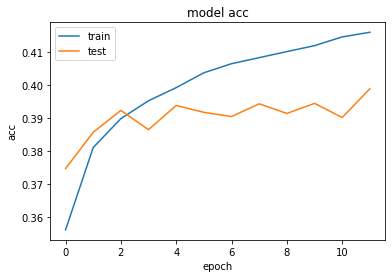

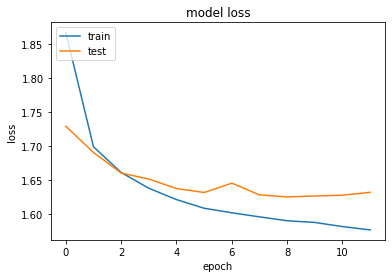

In [ ]:
# Simple Network

modelSN = Sequential()
modelSN.add(Embedding(len(weight_matrix), EMBEDDING_DIM, weights=[weight_matrix], input_length=max_words, trainable=False))
modelSN.add(Flatten())
modelSN.add(Dense(10, activation='softmax'))
# try using different optimizers and different optimizer configs
modelSN.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print(modelSN.summary())

saveBestModel = keras.callbacks.ModelCheckpoint('stanfordSentimentTreebank/best_modelSN.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Fit the model
SN = modelSN.fit(train_x, train_y, batch_size=batch_size, epochs=100, validation_data=(val_x, val_y), callbacks=[saveBestModel, earlyStopping])

# Final evaluation of the model
score, acc = modelSN.evaluate(test_x, test_y, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

plt.plot(SN.history['accuracy'])
plt.plot(SN.history['val_accuracy'])

plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(SN.history['loss'])
plt.plot(SN.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 56, 100)           40000100  
_________________________________________________________________
conv1d (Conv1D)              (None, 52, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 40,065,518
Trainable params: 65,418
Non-trainable params: 40,000,100
_________________________________________________________________
None
Epoch 1/100
96/96 [==============================] - 77s 802ms/step - loss: 1.7835 - accuracy: 0.3685 - val_loss: 1.6429 - val_accuracy: 0.3954
Epoch 2/100
96/96 [==============================] - 78s 815ms/step - loss: 1.5907 - a

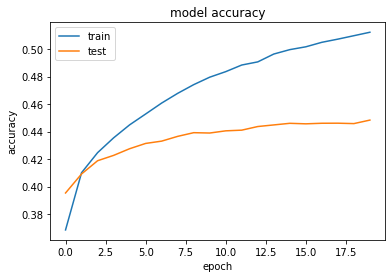

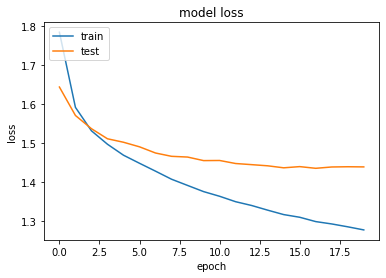

In [ ]:
# CNN 

modelCNN = Sequential()
modelCNN.add(Embedding(len(weight_matrix), EMBEDDING_DIM, weights=[weight_matrix], input_length=max_words, trainable=False))
modelCNN.add(Conv1D(128, 5, activation='relu'))
modelCNN.add(GlobalMaxPooling1D())
modelCNN.add(Dense(10, activation='softmax'))
# try using different optimizers and different optimizer configs
modelCNN.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print(modelCNN.summary())

saveBestModel = keras.callbacks.ModelCheckpoint('stanfordSentimentTreebank/best_modelCNN.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period = 1)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Fit the model
CNN = modelCNN.fit(train_x, train_y, batch_size=batch_size, epochs=100, validation_data=(val_x, val_y), callbacks=[saveBestModel, earlyStopping])
# Final evaluation of the model
score, acc = modelCNN.evaluate(test_x, test_y, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

plt.plot(CNN.history['accuracy'])
plt.plot(CNN.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(CNN.history['loss'])
plt.plot(CNN.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [18]:
# RNN-LSTM:

modelRNN = Sequential()
modelRNN.add(Embedding(len(weight_matrix), EMBEDDING_DIM, weights=[weight_matrix], input_length=max_words, trainable=False))
modelRNN.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
modelRNN.add(Dense(512, activation='relu'))
modelRNN.add(Dropout(0.5))
modelRNN.add(Dense(10, activation='softmax'))
# try using different optimizers and different optimizer configs
modelRNN.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print(modelRNN.summary())

'''saveBestModel = keras.callbacks.ModelCheckpoint('stanfordSentimentTreebank/best_modelRNN.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period = 1)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Fit the model
RNN = modelRNN.fit(train_x, train_y, batch_size=batch_size, epochs=100, validation_data=(val_x, val_y), callbacks=[saveBestModel, earlyStopping])
# Final evaluation of the model
score, acc = model.evaluate(test_x, test_y, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

plt.plot(RNN.history['acc'])
plt.plot(RNN.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(RNN.history['loss'])
plt.plot(RNN.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()'''

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 56, 100)           40000100  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 40,371,310
Trainable params: 371,210
Non-trainable params: 40,000,100
_________________________________________________________________
None


"saveBestModel = keras.callbacks.ModelCheckpoint('stanfordSentimentTreebank/best_modelRNN.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period = 1)\nearlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')\n\n# Fit the model\nRNN = modelRNN.fit(train_x, train_y, batch_size=batch_size, epochs=100, validation_data=(val_x, val_y), callbacks=[saveBestModel, earlyStopping])\n# Final evaluation of the model\nscore, acc = model.evaluate(test_x, test_y, batch_size=batch_size)\n\nprint('Test score:', score)\nprint('Test accuracy:', acc)\n\nplt.plot(RNN.history['acc'])\nplt.plot(RNN.history['val_acc'])\n\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train','test'], loc='upper left')\nplt.show()\n\nplt.plot(RNN.history['loss'])\nplt.plot(RNN.history['val_loss'])\n\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['tr

Epoch 1/2
96/96 [==============================] - 553s 6s/step - loss: 1.3310 - accuracy: 0.4720 - val_loss: 1.2763 - val_accuracy: 0.4880
Epoch 2/2
12/12 [==============================] - 14s 1s/step - loss: 1.2662 - accuracy: 0.4970
Test score: 1.2661806344985962
Test accuracy: 0.4970052242279053


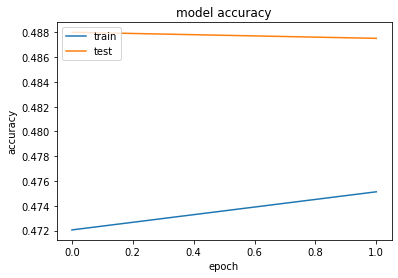

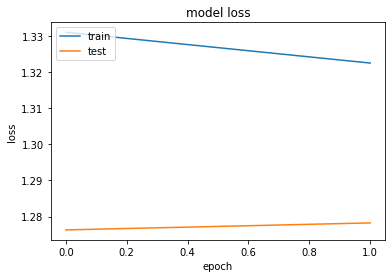

In [19]:
#RNN is performing good than ohter two models, so we would prefer to go with RNN-LSTM.


weight_path = '/content/drive/My Drive/Colab Notebooks/best_modelRNN.hdf5'
modelRNN.load_weights(weight_path)

saveBestModel = keras.callbacks.ModelCheckpoint('stanfordSentimentTreebank/best_modelRNN.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period = 1)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Fit the model
RNN = modelRNN.fit(train_x, train_y, batch_size=batch_size, epochs=2, validation_data=(val_x, val_y), callbacks=[saveBestModel, earlyStopping])
# Final evaluation of the model
score, acc = modelRNN.evaluate(test_x, test_y, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

plt.plot(RNN.history['accuracy'])
plt.plot(RNN.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(RNN.history['loss'])
plt.plot(RNN.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [24]:

#weight_path = 'stanfordSentimentTreebank/best_modelRNN.hdf5'
#modelRNN.load_weights(weight_path)
#modelRNN.summary()
data_sample = "I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned"

live_list = []
live_list_np = np.zeros((56,1))
# split the sentence into its words and remove any punctuations.
tokenizer = RegexpTokenizer(r'\w+')
data_sample_list = tokenizer.tokenize(data_sample)

labels = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
#word_idx['I']
# get index for the live stage
data_index = np.array([word_idx[word.lower()] if word.lower() in word_idx else 0 for word in data_sample_list])
data_index_np = np.array(data_index)

# padded with zeros of length 56 i.e maximum length
padded_array = np.zeros(len(data_sample)) # use the def maxSeqLen(training_data) function to detemine the padding length for your data
padded_array[:data_index_np.shape[0]] = data_index_np
data_index_np_pad = padded_array.astype(int)
live_list.append(data_index_np_pad)
live_list_np = np.asarray(live_list)
type(live_list_np)

# get score from the model
score = modelRNN.predict(live_list_np, batch_size=len(data_sample), verbose=0)
print(score)

single_score = np.round(np.dot(score, labels)/10,decimals=2)
print(single_score)
# weighted score of top 3 bands
top_3_index = np.argsort(score)[0][-3:]
top_3_scores = score[0][top_3_index]
top_3_weights = top_3_scores/np.sum(top_3_scores)
single_score_dot = np.round(np.dot(top_3_index, top_3_weights)/10, decimals = 2)

result = single_score_dot

print(result)

[[6.0841709e-01 3.1425208e-01 5.4754876e-02 1.7869163e-02 3.5779872e-03
  6.0924591e-04 3.7877329e-04 9.2883172e-05 3.8024380e-05 9.8702203e-06]]
[0.15]
0.04


The sentiment value for our single instance is 0.15 which means that our sentiment is predicted as negative, which actually is the case.